In [1]:
#В данном проекте я пытаюсь предсказать цену криптовалюты с использованием алгоритма LSTM

In [2]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from collections import defaultdict

In [3]:
#Настраиваем параметры для использования gpu
pl.seed_everything = 42
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("using device", device)

using device cuda:0


In [4]:
#Читаем датасет
df = pd.read_csv("Binance_BTCUSDT_minute.csv", parse_dates=["date"])
df = df.sort_values(by="date").reset_index(drop=True)
df.head()
df.shape

(273288, 10)

In [5]:
#Смещаем целевую переменную
df["prev_close"] = df.shift(1)["close"]
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,prev_close
0,1599856800000,2020-09-11 20:40:00,BTC/USDT,10317.00,10317.01,10314.36,10316.00,32.997684,340398.477553,342,NaN
1,1599856860000,2020-09-11 20:41:00,BTC/USDT,10316.00,10321.09,10316.00,10319.50,16.328427,168497.705251,256,10316.00
2,1599856920000,2020-09-11 20:42:00,BTC/USDT,10319.50,10320.31,10318.49,10319.34,12.123487,125108.931436,193,10319.50
3,1599856980000,2020-09-11 20:43:00,BTC/USDT,10319.34,10320.14,10318.89,10319.00,13.548103,139806.963489,187,10319.34
4,1599857040000,2020-09-11 20:44:00,BTC/USDT,10318.99,10319.72,10316.58,10319.47,14.466964,149266.708094,284,10319.00


In [6]:
#Считаем дельту
tqdm.pandas()
df["close_change"] = df.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis=1
)

  0%|          | 0/273288 [00:00<?, ?it/s]

In [7]:
#Добавляем новые признаки
rows = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
        day_of_week=row.date.dayofweek,
        day_of_month=row.date.day,
        week_of_year=row.date.week,
        month=row.date.month,
        open=row.open,
        high=row.high,
        low=row.low,
        close_change=row.close_change,
        close=row.close
    )

    rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/273288 [00:00<?, ?it/s]

In [8]:
features_df.shape

(273288, 9)

In [9]:
features_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close_change,close
0,4,11,37,9,10317.00,10317.01,10314.36,0.00,10316.00
1,4,11,37,9,10316.00,10321.09,10316.00,3.50,10319.50
2,4,11,37,9,10319.50,10320.31,10318.49,-0.16,10319.34
3,4,11,37,9,10319.34,10320.14,10318.89,-0.34,10319.00
4,4,11,37,9,10318.99,10319.72,10316.58,0.47,10319.47


In [10]:
#Разбиваем на трейн и тест
train_size = int(len(features_df)*.9)
train_size

245959

In [11]:
train_df, test_df = features_df[:train_size], features_df[train_size + 1:]
train_df.shape, test_df.shape

((245959, 9), (27328, 9))

In [12]:
#Масштабируем признаки
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [13]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [14]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

In [15]:
train_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close_change,close
0,0.333333,-0.333333,0.384615,0.454545,-0.993056,-0.993463,-0.992628,0.242895,-0.993097
1,0.333333,-0.333333,0.384615,0.454545,-0.993097,-0.993294,-0.992559,0.244938,-0.992952
2,0.333333,-0.333333,0.384615,0.454545,-0.992952,-0.993326,-0.992456,0.242802,-0.992959
3,0.333333,-0.333333,0.384615,0.454545,-0.992959,-0.993333,-0.992439,0.242697,-0.992973
4,0.333333,-0.333333,0.384615,0.454545,-0.992973,-0.993351,-0.992535,0.243169,-0.992953


In [16]:
#Создаем функцию по формированию последовательности
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length)):
        sequence = input_data[i:i+sequence_length]
        label_position = i+sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence, label))
    return sequences

In [17]:
#Создаем пример и обкатываем последовательности на нем
sample_data = pd.DataFrame(dict(
    feature_1=[1,2,3,4,5],
    label=[6,7,8,9,10]
))

sample_data.head()

,feature_1,label
0,1,6
1,2,7
2,3,8
3,4,9
4,5,10


In [18]:
sample_sequences = create_sequences(sample_data, "label", sequence_length=3)

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
#Все ок, создаем целевые последовательности
SEQUENCE_LENGTH = 120

train_sequences = create_sequences(train_df, "close", SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df, "close", SEQUENCE_LENGTH)

  0%|          | 0/245839 [00:00<?, ?it/s]

  0%|          | 0/27208 [00:00<?, ?it/s]

In [20]:
#Создаем класс преобразования датасета в тензор
class BTCDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).float()
        )

In [21]:
#Создаем класс для преобразования данных в модуль pytorch ligthning
class BTCPriceDataModule(pl.LightningDataModule):

    def __init__(
        self, train_sequences, test_sequences, batch_size=8
    ):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BTCDataset(self.train_sequences)
        self.test_dataset = BTCDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1
        )

In [22]:
N_EPOCHS = 8
BATCH_SIZE = 64

data_module = BTCPriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [23]:
train_dataset = BTCDataset(train_sequences)

In [24]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([120, 9])
torch.Size([])
tensor(-0.9903)


In [25]:
#Создаем класс LSTM
class PricePredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        batch_first=True,
        num_layers=n_layers,
        dropout=0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _,(hidden, _) = self.lstm(x)
        out = hidden[-1]
        return self.regressor(out)

In [26]:
#Создаем класс для проверки результатов работы модели и переобучения
class BTCPricePredictor(pl.LightningModule):
    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [27]:
model = BTCPricePredictor(n_features=train_df.shape[1])
model = model.to(device)

In [28]:
for item in data_module.train_dataloader():
    #print(item.keys())
    #break
    print(item["sequence"].shape)
    print(item["label"].shape)
    #print(item["label"])
    break

torch.Size([64, 120, 9])
torch.Size([64])


In [29]:
#Перед обучением нужно прописать параметры по формированию контрольных точек и параметры тренера
from torch.utils.tensorboard import SummaryWriter
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="btc-price")

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback,early_stopping_callback],
    max_epochs=N_EPOCHS
    #gpus=True
    #progress_bar_refresh_rate=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [30]:
#Обучаем модель
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/mandarin/anaconda3/envs/mlenv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/mandarin/pyprog/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | PricePredictionModel | 203 K  | train
1 | criterion | MSELoss              | 0      | train
-----------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estim

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/mandarin/anaconda3/envs/mlenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 3842: 'val_loss' reached 0.11395 (best 0.11395), saving model to '/home/mandarin/pyprog/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 7684: 'val_loss' reached 0.04723 (best 0.04723), saving model to '/home/mandarin/pyprog/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2, global step 11526: 'val_loss' reached 0.02326 (best 0.02326), saving model to '/home/mandarin/pyprog/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 15368: 'val_loss' was not in top 1


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 19210: 'val_loss' was not in top 1


In [31]:
#Берем самую лучшую модель
trained_model = BTCPricePredictor.load_from_checkpoint(
    "checkpoints/best-checkpoint.ckpt",
   n_features=train_df.shape[1]
)

In [32]:
trained_model.freeze()

In [33]:
#Используем обученную модель для тестовых данных для получения целевых переменных
test_dataset = BTCDataset(test_sequences)
predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    sequence = sequence.to(device)
    label = item["label"]
    label = label.to(device)

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/27208 [00:00<?, ?it/s]

In [34]:
len(predictions), len(test_df)

(27208, 27328)

In [35]:
#Кол-во предсказанных значений и кол-во тестовых данных не соответствует друг другу, нужно вычесть кол-во последовательностей для сравнения данных
len(test_df) - SEQUENCE_LENGTH

27208

In [36]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close_change,close
245960,-1.0,-1.0,-0.692308,-0.636364,0.624959,0.625899,0.621585,0.176448,0.620668
245961,-1.0,-1.0,-0.692308,-0.636364,0.620549,0.623429,0.620050,0.283102,0.623527
245962,-1.0,-1.0,-0.692308,-0.636364,0.623528,0.626200,0.622503,0.255128,0.624397
245963,-1.0,-1.0,-0.692308,-0.636364,0.624246,0.625320,0.622957,0.220180,0.622782
245964,-1.0,-1.0,-0.692308,-0.636364,0.622783,0.624252,0.623575,0.263818,0.624270


In [37]:
#Проводим обратное масштабирование для сравнения данных
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

In [38]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [39]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [40]:
labels_descaled[:5]

array([49273.18031831, 49240.86975907, 49205.17003054, 49181.88959693,
       49073.28969868])

In [41]:
test_data = df[train_size +1:]
len(test_data), len(test_df)

(27328, 27328)

In [42]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
len(test_sequences_data), len(test_sequences)

(27208, 27208)

In [43]:
test_sequences_data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,prev_close,close_change
246080,1614647340000,2021-03-02 01:09:00,BTC/USDT,49219.14,49286.46,49195.55,49273.18,32.294265,1.590369e+06,933,49220.10,53.08
246081,1614647400000,2021-03-02 01:10:00,BTC/USDT,49273.97,49278.37,49212.81,49240.87,22.888346,1.127200e+06,685,49273.18,-32.31
246082,1614647460000,2021-03-02 01:11:00,BTC/USDT,49240.87,49241.00,49200.00,49205.17,19.337932,9.518597e+05,831,49240.87,-35.70
246083,1614647520000,2021-03-02 01:12:00,BTC/USDT,49200.20,49205.32,49178.15,49181.89,18.227805,8.967020e+05,706,49205.17,-23.28
246084,1614647580000,2021-03-02 01:13:00,BTC/USDT,49181.48,49181.48,49060.60,49073.29,29.791624,1.463463e+06,1163,49181.89,-108.60


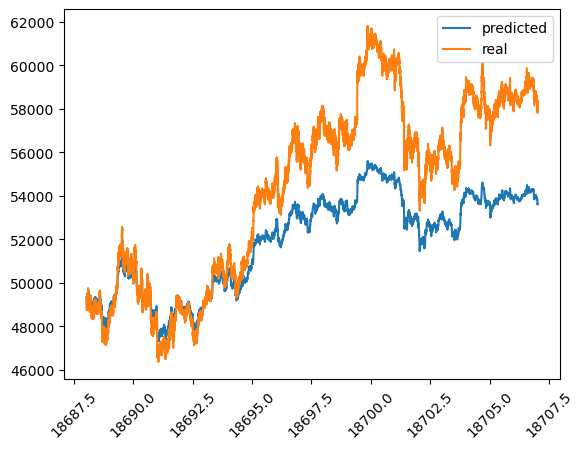

In [44]:
#Визуализация результатов
dates = matplotlib.dates.date2num(test_sequences_data.date.tolist())
plt.plot(dates, predictions_descaled, "-", label="predicted")
plt.plot(dates, labels_descaled, "-", label="real")
plt.xticks(rotation=45)
plt.legend()

In [45]:
#Вывод: С первого взгляда модель работает неплохо, точно лучше предыдущих 2-х проектов, можно попробовать добавить новые признаки и посмотреть результаты.